In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
df_all_path = "/content/drive/MyDrive/IEOR 4418 Project/output_data/full_hourly_results_detailed.csv"
df_summary_path = "/content/drive/MyDrive/IEOR 4418 Project/output_data/full_hourly_results_summary.csv"

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set the aesthetic style
sns.set_style("whitegrid")
colors = {'door': '#FF6B6B', 'corner': '#4ECDC4', 'hybrid': '#45B7D1'}
order = ['door', 'corner', 'hybrid']

In [54]:
df_all = pd.read_csv(df_all_path)
df_summary = pd.read_csv(df_summary_path)

In [55]:
df_all.head()

,scenario,service_type,wait_min,ride_min,walk_min,total_min,violation,service_date,service_hour,num_vehicles,total_requests
0,door,door,5.456379,30.446652,0.0,35.903030,True,2025-10-01,0,10,55
1,door,door,7.869707,28.186485,0.0,36.056192,False,2025-10-01,0,10,55
2,door,door,5.494172,15.310813,0.0,20.804984,False,2025-10-01,0,10,55
3,door,door,4.877992,29.990335,0.0,34.868327,False,2025-10-01,0,10,55
4,door,door,12.906979,12.891918,0.0,25.798896,False,2025-10-01,0,10,55


## General

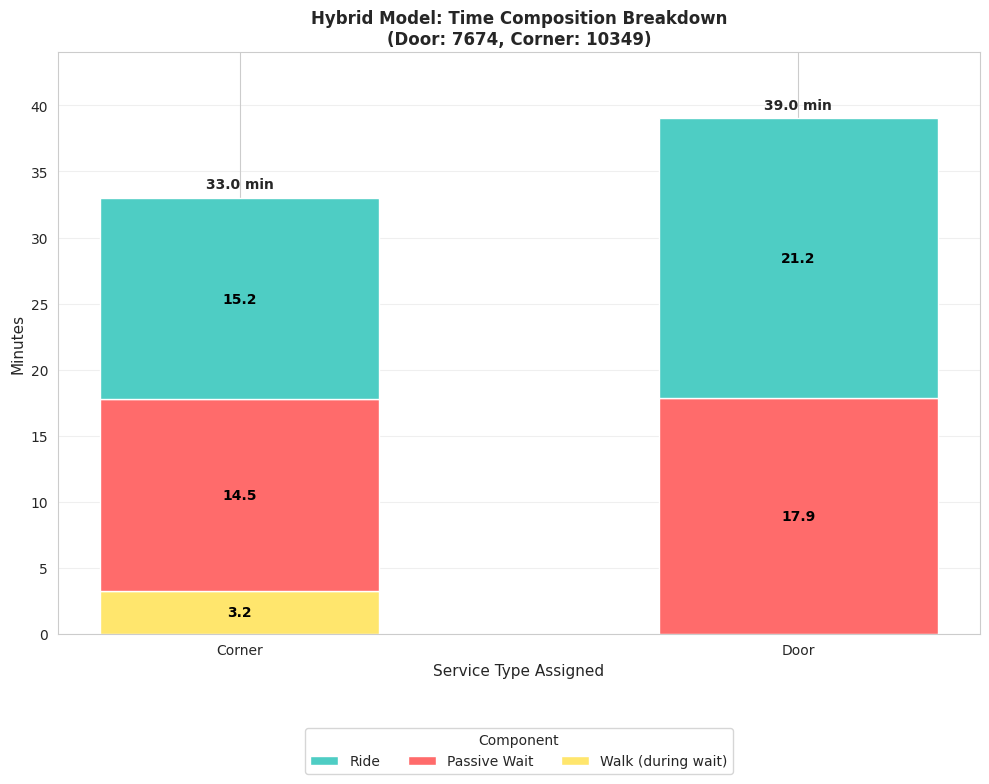

In [56]:
import matplotlib.pyplot as plt
import pandas as pd

# (Assuming df_all is already loaded in your environment)
fig, ax6 = plt.subplots(figsize=(10,8))

df_hybrid = df_all[df_all['scenario'] == 'hybrid'].copy()

# 1. Aggregation: Mean times
hybrid_breakdown = df_hybrid.groupby('service_type')[['wait_min', 'ride_min', 'walk_min']].mean()

# --- LOGIC CORRECTION ---
# Split 'Total Wait' into 'Active Walking' and 'Passive Waiting'
# Passive Wait = Total Wait - Walk Time
hybrid_breakdown['passive_wait'] = hybrid_breakdown['wait_min'] - hybrid_breakdown['walk_min']
# Ensure no negative values (just in case walk > wait outlier exists, though unlikely)
hybrid_breakdown['passive_wait'] = hybrid_breakdown['passive_wait'].clip(lower=0)

# Get counts for the title
counts = df_hybrid['service_type'].value_counts()
door_count = counts.get('door', 0)
corner_count = counts.get('corner', 0)

# 2. Plot Stacked Bar Chart
# Layer 1 (Bottom): Walking (This is the active part of the wait)
p1 = ax6.bar(hybrid_breakdown.index.str.title(), hybrid_breakdown['walk_min'],
              label='Walk (during wait)', color='#FFE66D', width=0.5)

# Layer 2 (Middle): Passive Waiting (The rest of the wait time)
# Stacked on top of Walk
p2 = ax6.bar(hybrid_breakdown.index.str.title(), hybrid_breakdown['passive_wait'],
              bottom=hybrid_breakdown['walk_min'],
              label='Passive Wait', color='#FF6B6B', width=0.5)

# Layer 3 (Top): Ride
# Stacked on top of Total Wait (which is Walk + Passive Wait)
total_wait = hybrid_breakdown['walk_min'] + hybrid_breakdown['passive_wait']
p3 = ax6.bar(hybrid_breakdown.index.str.title(), hybrid_breakdown['ride_min'],
              bottom=total_wait,
              label='Ride', color='#4ECDC4', width=0.5)

# 3. Styling
ax6.set_title(f'Hybrid Model: Time Composition Breakdown\n(Door: {door_count}, Corner: {corner_count})',
              fontsize=12, fontweight='bold')
ax6.set_ylabel('Minutes', fontsize=11)
ax6.set_xlabel('Service Type Assigned', fontsize=11)

# Add Legend (reverse order to match stack visual: Ride -> Passive Wait -> Walk)
handles, labels = ax6.get_legend_handles_labels()
ax6.legend(handles[::-1], labels[::-1], title='Component', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
ax6.grid(axis='y', alpha=0.3)

# Calculate totals for Y-limit and labels (Now Total = Wait + Ride)
totals = hybrid_breakdown['wait_min'] + hybrid_breakdown['ride_min']
ax6.set_ylim(0, max(totals) + 5)

# 4. Add Labels to Each Segment
def add_segment_labels(rects):
    for rect in rects:
        height = rect.get_height()
        if height > 0.5: # Only label if segment is large enough
            ax6.text(rect.get_x() + rect.get_width()/2.,
                      rect.get_y() + height/2.,
                      f'{height:.1f}',
                      ha='center', va='center', color='black', fontsize=10, fontweight='bold')

add_segment_labels(p1)
add_segment_labels(p2)
add_segment_labels(p3)

# 5. Add Total Labels on Top
for i, total in enumerate(totals):
    ax6.text(i, total + 0.5, f'{total:.1f} min', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

/tmp/ipython-input-2995538614.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=means.index, y=means.values, ax=axes[i], palette=colors, order=order)
/tmp/ipython-input-2995538614.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=means.index, y=means.values, ax=axes[i], palette=colors, order=order)
/tmp/ipython-input-2995538614.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=means.index, y=means.values, ax=axes[i], palette=colors, order=order)


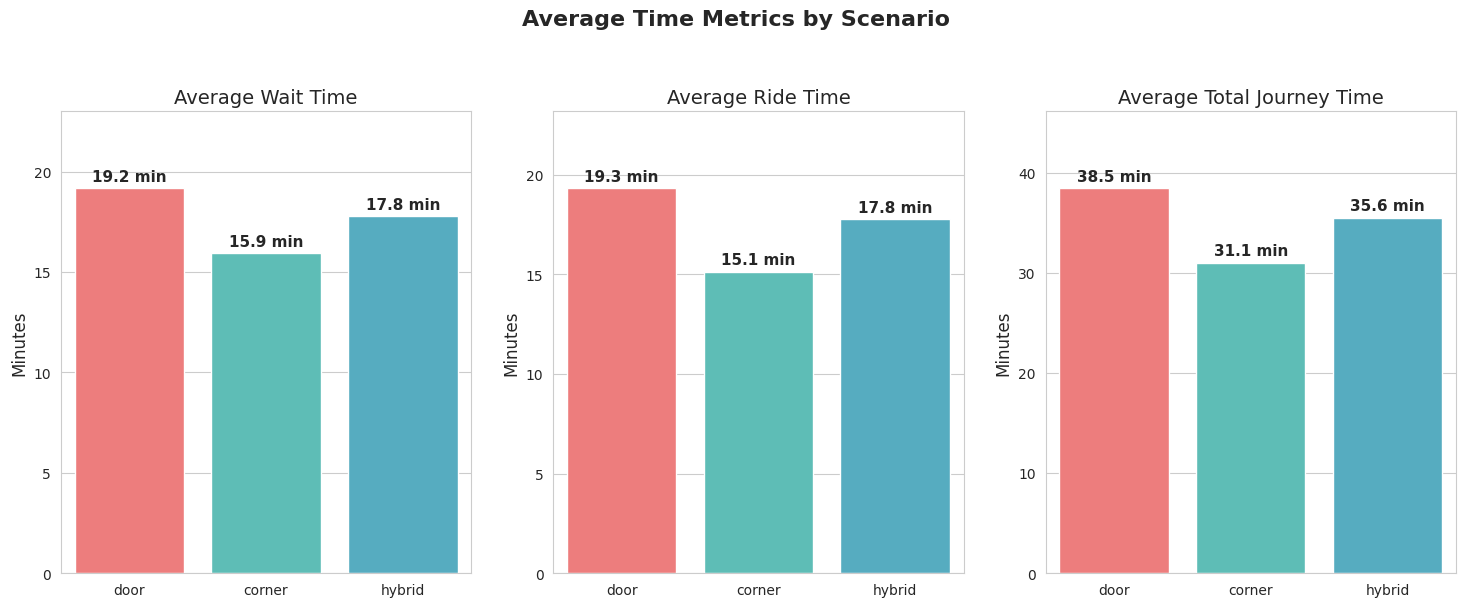

In [57]:
# ==============================================================================
# 1. AVERAGE TIMES (3 Separate Bar Graphs)
# ==============================================================================
fig1, axes = plt.subplots(1, 3, figsize=(18, 6))
fig1.suptitle('Average Time Metrics by Scenario', fontsize=16, fontweight='bold', y=1.05)

metrics = [
    ('wait_min', 'Average Wait Time'),
    ('ride_min', 'Average Ride Time'),
    ('total_min', 'Average Total Journey Time')
]

for i, (col, title) in enumerate(metrics):
    # Calculate means
    means = df_all.groupby('scenario')[col].mean().reindex(order)

    # Plot
    sns.barplot(x=means.index, y=means.values, ax=axes[i], palette=colors, order=order)
    axes[i].set_title(title, fontsize=14)
    axes[i].set_ylabel('Minutes', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylim(0, means.max() * 1.2) # Give space for labels

    # Add Labels on top
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%.1f min', padding=3, fontsize=11, fontweight='bold')


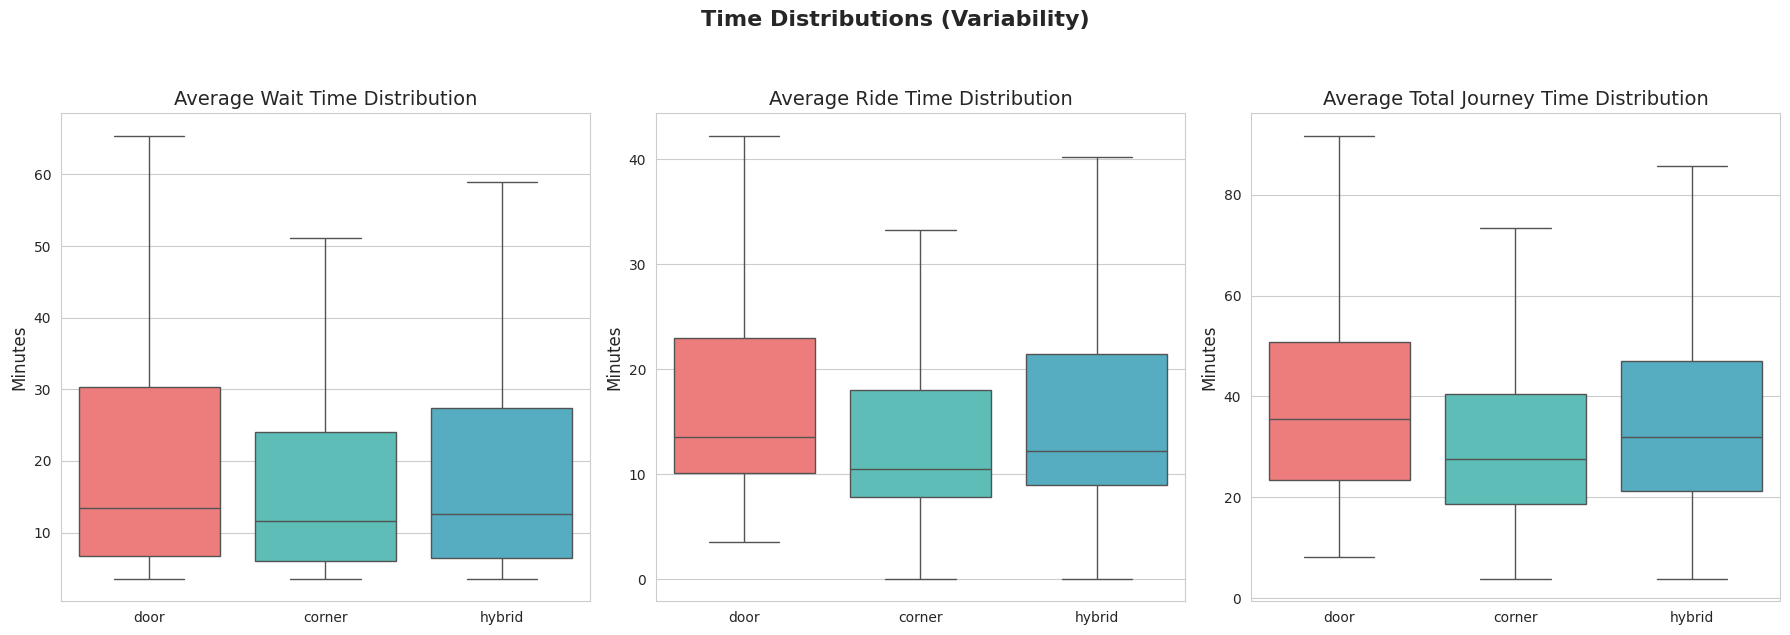

In [58]:
fig2, axes = plt.subplots(1, 3, figsize=(18, 6))
fig2.suptitle('Time Distributions (Variability)', fontsize=16, fontweight='bold', y=1.05)

for i, (col, title) in enumerate(metrics):
    # Fix: Assign 'scenario' to 'hue' and set 'legend=False'
    sns.boxplot(data=df_all, x='scenario', y=col, ax=axes[i], hue='scenario', palette=colors, order=order, showfliers=False, legend=False)
    axes[i].set_title(f'{title} Distribution', fontsize=14)
    axes[i].set_ylabel('Minutes', fontsize=12)
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

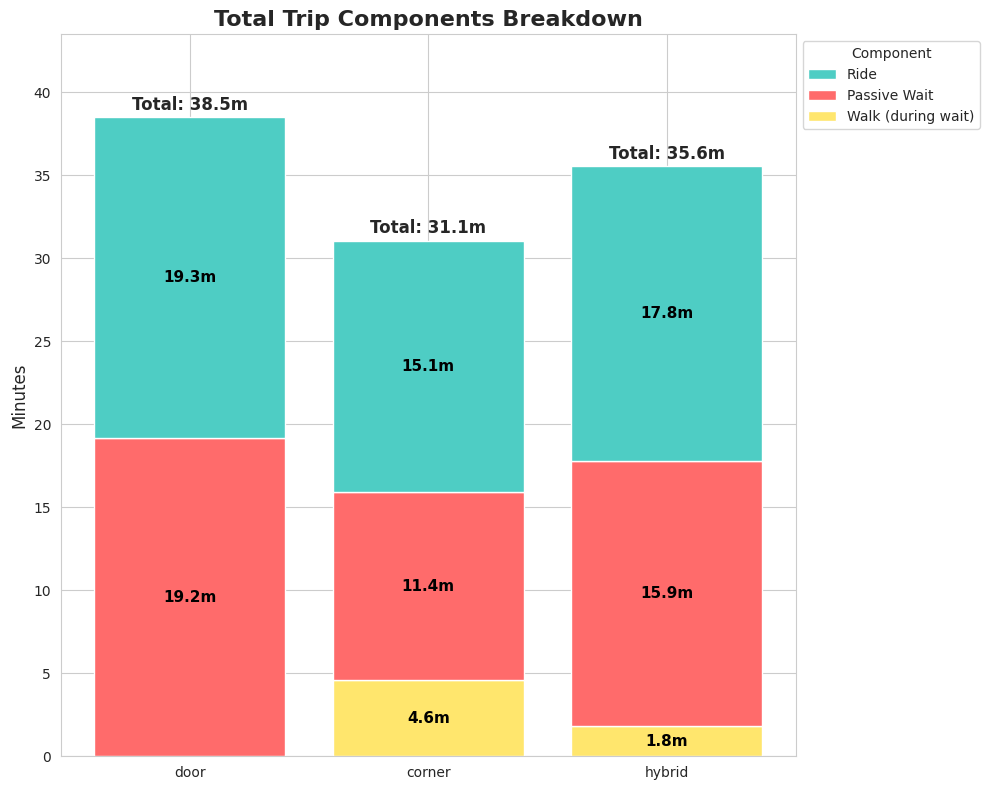

In [59]:
import matplotlib.pyplot as plt
import pandas as pd

# 3. TIME COMPONENTS BREAKDOWN (Stacked Bar)
# ==============================================================================
fig3, ax = plt.subplots(figsize=(10, 8))

# 1. Aggregate data
# We assume df_all and order are already defined in your environment
components = df_all.groupby('scenario')[['wait_min', 'ride_min', 'walk_min']].mean().reindex(order)

# 2. Logic Correction: Split Total Wait into Active (Walk) and Passive
# Passive Wait = Total Wait - Walk Time
components['passive_wait'] = components['wait_min'] - components['walk_min']
components['passive_wait'] = components['passive_wait'].clip(lower=0) # Safety clip

# 3. Plot Stacked Bar
# Layer 1 (Bottom): Walk (Active Wait)
p1 = ax.bar(components.index, components['walk_min'],
            label='Walk (during wait)', color='#FFE66D')

# Layer 2 (Middle): Passive Wait (Stacked on Walk)
p2 = ax.bar(components.index, components['passive_wait'],
            bottom=components['walk_min'],
            label='Passive Wait', color='#FF6B6B')

# Layer 3 (Top): Ride (Stacked on Total Wait, which is Walk + Passive)
# Note: components['walk_min'] + components['passive_wait'] equals original 'wait_min'
p3 = ax.bar(components.index, components['ride_min'],
            bottom=components['walk_min'] + components['passive_wait'],
            label='Ride', color='#4ECDC4')

# 4. Formatting
ax.set_title('Total Trip Components Breakdown', fontsize=16, fontweight='bold')
ax.set_ylabel('Minutes', fontsize=12)

# Legend reversed to match visual stack (Ride -> Passive -> Walk)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1, 1), title="Component")

# Set Y-Limit based on Total Trip Time (Wait + Ride)
# Note: Since Walk is now *inside* Wait, Total = Wait + Ride
trip_totals = components['wait_min'] + components['ride_min']
ax.set_ylim(0, trip_totals.max() + 5)

# 5. Function to add labels to the center of the bars
def add_labels(plots):
    for bar in plots:
        height = bar.get_height()
        if height > 0.5: # Only label if segment is visible
            ax.text(bar.get_x() + bar.get_width()/2.,
                    bar.get_y() + height/2.,
                    f'{height:.1f}m',
                    ha='center', va='center',
                    color='black', fontweight='bold', fontsize=11)

# Add labels to all segments
add_labels(p1)
add_labels(p2)
add_labels(p3)

# 6. Add Total labels on top
for i, total in enumerate(trip_totals):
    ax.text(i, total + 0.2, f'Total: {total:.1f}m', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

✅ Saved ordered hourly comparison.


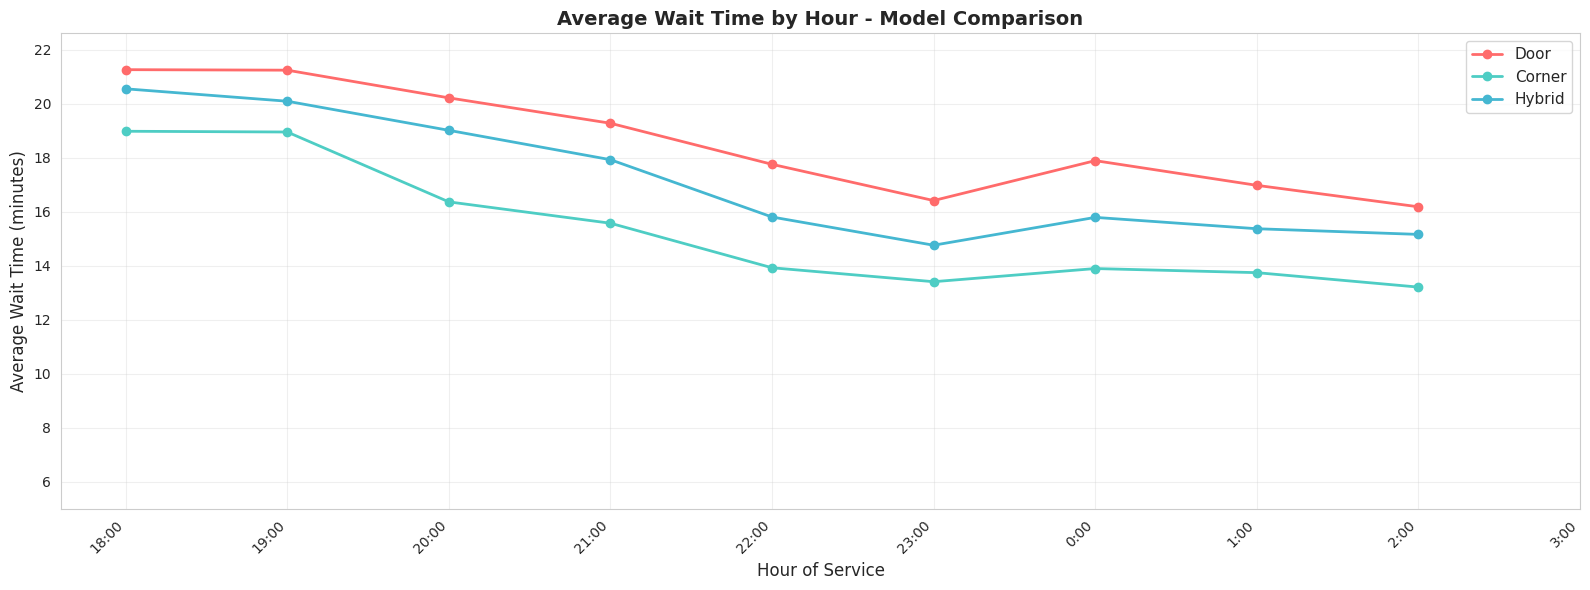

In [66]:
# Define the logical order for your service day
service_hours_order = [18, 19, 20, 21, 22, 23, 0, 1, 2, 3]

fig2, ax = plt.subplots(1, 1, figsize=(16, 6))

# Plot average wait time by hour for each scenario
hourly_summary = df_summary.copy()

for scenario_col, label, color in [('door_avg_wait', 'Door', '#FF6B6B'),
                                    ('corner_avg_wait', 'Corner', '#4ECDC4'),
                                    ('hybrid_avg_wait', 'Hybrid', '#45B7D1')]:
    # 1. Group by hour and get mean
    hourly_avg = hourly_summary.groupby('hour')[scenario_col].mean()

    # 2. Reindex to enforce the specific service order (18 -> 3)
    # This aligns the data to our custom list and handles any missing hours gracefully
    hourly_avg_ordered = hourly_avg.reindex(service_hours_order)

    # 3. Plot using range(len) for x-axis to keep the visual sequence linear
    # We plot .values to ignore the numeric index (0, 1... 18...) which causes the jump
    ax.plot(range(len(service_hours_order)), hourly_avg_ordered.values, marker='o',
            label=label, linewidth=2, markersize=6, color=color)

ax.set_xlabel('Hour of Service', fontsize=12)
ax.set_ylabel('Average Wait Time (minutes)', fontsize=12)
ax.set_title('Average Wait Time by Hour - Model Comparison', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

# 4. Set custom x-ticks to match our ordered labels
ax.set_xticks(range(len(service_hours_order)))
ax.set_xticklabels([f'{h}:00' for h in service_hours_order], rotation=45, ha='right')

ax.set_ylim(5, hourly_avg_ordered.max() * 1.1)

plt.tight_layout()
plt.savefig('hourly_wait_time_comparison_ordered.png', dpi=300, bbox_inches='tight')
print(f"✅ Saved ordered hourly comparison.")

## Before 8 v.s. After 8

Detailed Metrics by Time Interval
                        wait_min                               ride_min  \
Time_Interval After 8 PM (20-03) Before 8 PM (18-20) After 8 PM (20-03)   
scenario                                                                  
corner                 14.840794           18.917753          14.780012   
door                   18.412846           21.261691          18.778442   
hybrid                 16.851885           20.363756          17.098736   

                                           total_min                      
Time_Interval Before 8 PM (18-20) After 8 PM (20-03) Before 8 PM (18-20)  
scenario                                                                  
corner                  16.123040          29.620807           35.040793  
door                    20.833358          37.191288           42.095049  
hybrid                  19.587691          33.950621           39.951446  


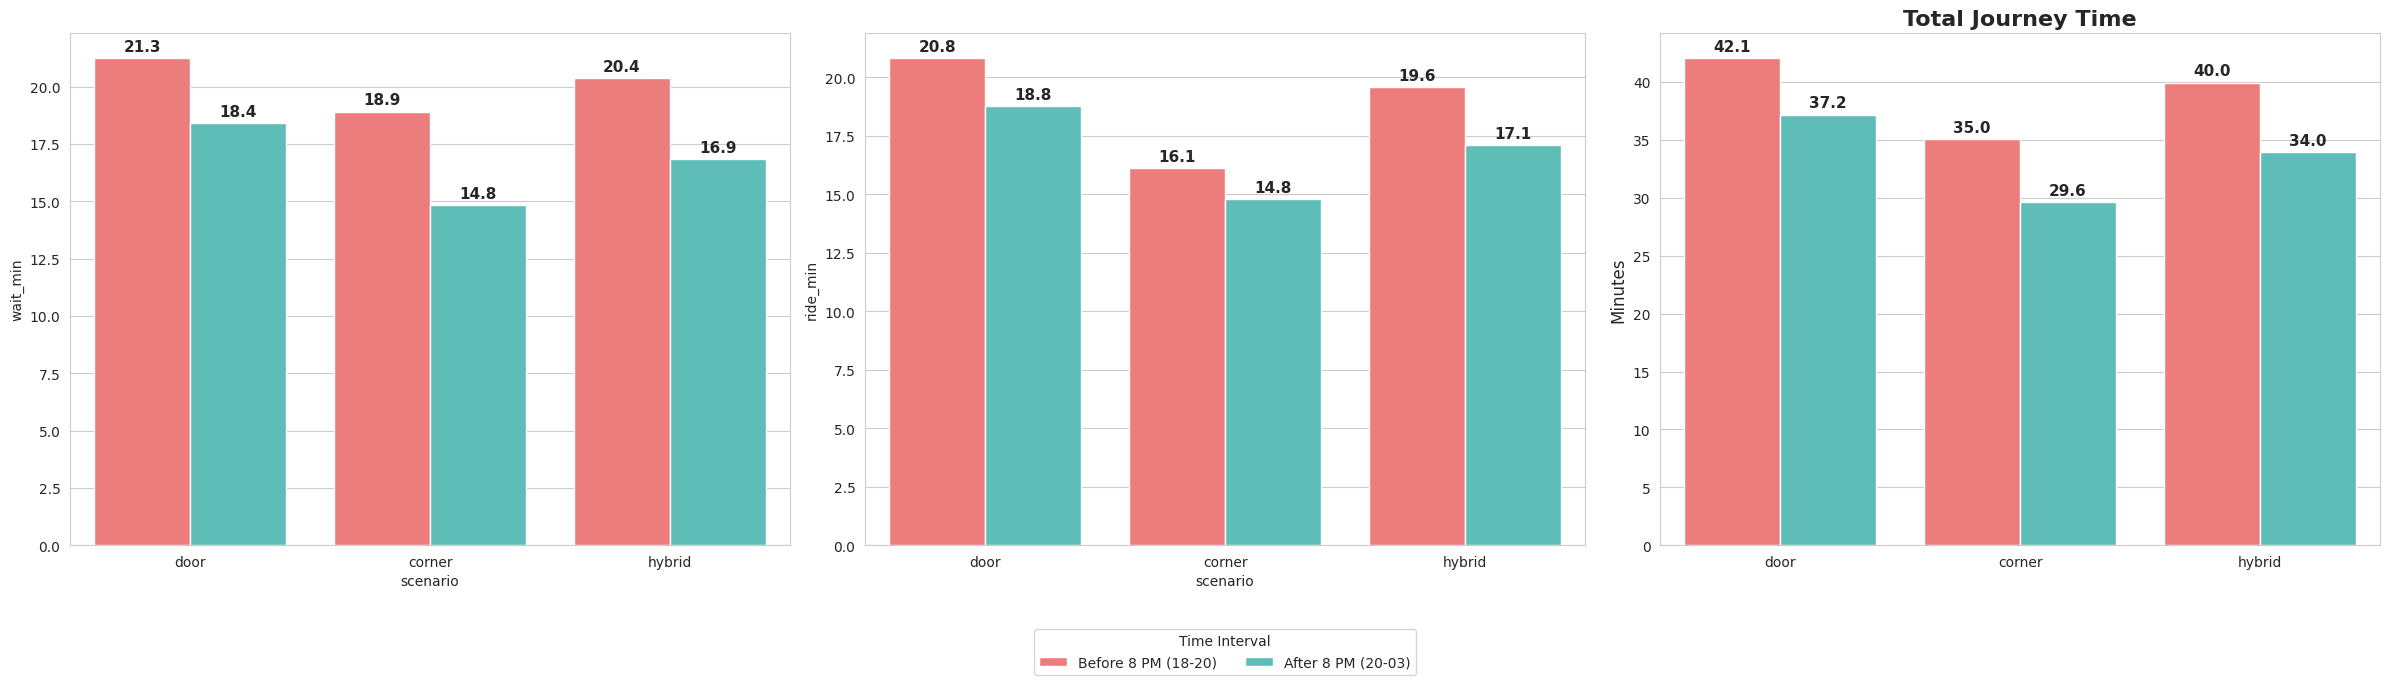

In [61]:
# 1. Define the Time Intervals
# "Before 8 PM" = 18, 19
# "After 8 PM"  = 20, 21, 22, 23, 0, 1, 2, 3
def categorize_time(hour):
    if 18 <= hour < 20:
        return 'Before 8 PM (18-20)'
    else:
        return 'After 8 PM (20-03)'

# 2. Apply classification to the dataset
# We need the 'df_all' dataframe from your simulation results
df_analysis = df_all.copy()
df_analysis['Time_Interval'] = df_analysis['service_hour'].apply(categorize_time)

# 3. Compute the Metrics (Aggregating Means)
# Now including 'total_min' which is Wait + Ride + Walk
stats = df_analysis.groupby(['scenario', 'Time_Interval'])[['wait_min', 'ride_min', 'total_min']].mean().reset_index()

# Print the specific values for verification
print("Detailed Metrics by Time Interval")
print(stats.pivot(index='scenario', columns='Time_Interval', values=['wait_min', 'ride_min', 'total_min']))
print("=========================================")

# 4. Visualization - Now with 3 Charts
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(24, 7)) # Increased width for 3 charts

# Define colors
palette = {'Before 8 PM (18-20)': '#FF6B6B', 'After 8 PM (20-03)': '#4ECDC4'}
order = ['door', 'corner', 'hybrid'] # Consistent order

hue_order = ['Before 8 PM (18-20)', 'After 8 PM (20-03)']

# CHART 1: WAIT TIMES
sns.barplot(data=stats, x='scenario', y='wait_min', hue='Time_Interval', ax=axes[0],
            palette=palette, order=order, hue_order=hue_order)

# CHART 2: RIDE TIMES
sns.barplot(data=stats, x='scenario', y='ride_min', hue='Time_Interval', ax=axes[1],
            palette=palette, order=order, hue_order=hue_order)

# CHART 3: TOTAL TRAVEL TIME
sns.barplot(data=stats, x='scenario', y='total_min', hue='Time_Interval', ax=axes[2],
            palette=palette, order=order,hue_order=hue_order)
axes[2].set_title('Total Journey Time', fontsize=16, fontweight='bold')
axes[2].set_ylabel('Minutes', fontsize=12)
axes[2].set_xlabel('')

# Add value labels to all bars
for ax in axes:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f', padding=3, fontsize=11, fontweight='bold')
    # Move legend to bottom or hide duplicates
    ax.legend(title='Time Interval', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

# Only keep legend on the middle chart to save space
axes[0].get_legend().remove()
axes[2].get_legend().remove()

plt.tight_layout()
plt.savefig('time_interval_analysis_full.png', dpi=300)
plt.show()

## Weekday v.s. Weekend

=== DETAILED METRICS: WEEKDAY VS WEEKEND ===
                  wait_min                            ride_min  \
Day_Type Weekday (Mon-Fri) Weekend (Sat-Sun) Weekday (Mon-Fri)   
scenario                                                         
corner           16.016481         15.666431         15.218171   
door             19.268945         18.857784         19.470703   
hybrid           17.950685         17.260111         17.916653   

                                   total_min                    
Day_Type Weekend (Sat-Sun) Weekday (Mon-Fri) Weekend (Sat-Sun)  
scenario                                                        
corner           14.884861         31.234652         30.551292  
door             18.854612         38.739647         37.712396  
hybrid           17.259383         35.867339         34.519494  


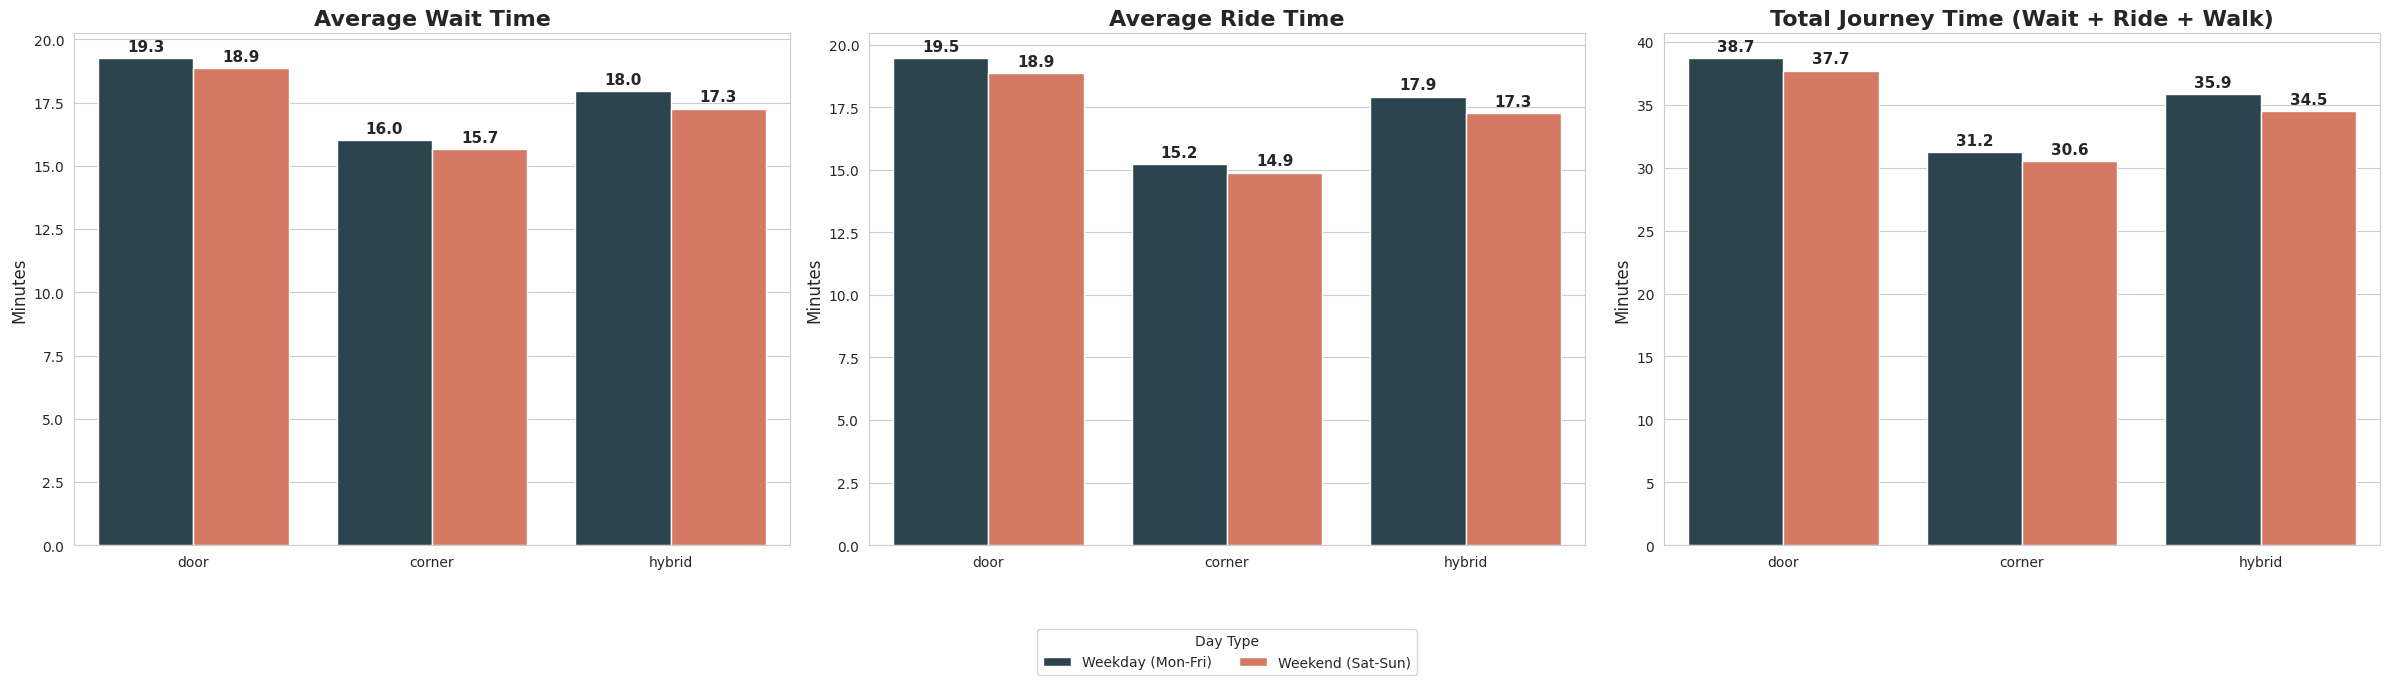

In [62]:
# Define Weekday vs Weekend logic
def get_day_type(date_val):
    # Convert to datetime if strictly necessary, though pandas apply usually handles it
    dt = pd.to_datetime(date_val)
    # 0=Monday, 4=Friday, 5=Saturday, 6=Sunday
    if dt.dayofweek < 5:
        return 'Weekday (Mon-Fri)'
    else:
        return 'Weekend (Sat-Sun)'

# Apply classification to the dataset
# We work with 'df_all' which contains the detailed trip records
df_analysis = df_all.copy()
# Ensure service_date is datetime format
df_analysis['service_date'] = pd.to_datetime(df_analysis['service_date'])
df_analysis['Day_Type'] = df_analysis['service_date'].apply(get_day_type)

# Compute the Metrics (Aggregating Means)
stats = df_analysis.groupby(['scenario', 'Day_Type'])[['wait_min', 'ride_min', 'total_min']].mean().reset_index()

# Print the specific values for verification
print("=== DETAILED METRICS: WEEKDAY VS WEEKEND ===")
print(stats.pivot(index='scenario', columns='Day_Type', values=['wait_min', 'ride_min', 'total_min']))
print("============================================")

# Visualization
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# Define colors
palette = {'Weekday (Mon-Fri)': '#264653', 'Weekend (Sat-Sun)': '#E76F51'} # Dark blue vs Orange
order = ['door', 'corner', 'hybrid']

# CHART 1: WAIT TIMES
sns.barplot(data=stats, x='scenario', y='wait_min', hue='Day_Type', ax=axes[0], palette=palette, order=order)
axes[0].set_title('Average Wait Time', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Minutes', fontsize=12)
axes[0].set_xlabel('')

# CHART 2: RIDE TIMES
sns.barplot(data=stats, x='scenario', y='ride_min', hue='Day_Type', ax=axes[1], palette=palette, order=order)
axes[1].set_title('Average Ride Time', fontsize=16, fontweight='bold')
axes[1].set_ylabel('Minutes', fontsize=12)
axes[1].set_xlabel('')

# CHART 3: TOTAL TRAVEL TIME
sns.barplot(data=stats, x='scenario', y='total_min', hue='Day_Type', ax=axes[2], palette=palette, order=order)
axes[2].set_title('Total Journey Time (Wait + Ride + Walk)', fontsize=16, fontweight='bold')
axes[2].set_ylabel('Minutes', fontsize=12)
axes[2].set_xlabel('')

# Formatting
for ax in axes:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f', padding=3, fontsize=11, fontweight='bold')
    ax.legend(title='Day Type', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

# Clean up legends
axes[0].get_legend().remove()
axes[2].get_legend().remove()

plt.tight_layout()
plt.savefig('weekday_vs_weekend_analysis.png', dpi=300)
plt.show()

In [63]:
# SUMMARY STATISTICS TABLE


summary_table = df_all.groupby('scenario').agg({
    'wait_min': ['mean', 'median', 'std', 'min', 'max'],
    'ride_min': ['mean', 'median'],
    'walk_min': ['mean', 'max'],
    'total_min': ['mean', 'median', 'std', 'min', 'max']
}).round(2)

print("\n" + summary_table.to_string())

# Save to CSV
summary_table.to_csv('model_comparison_statistics.csv')
print(f"\n✅ Saved statistics table to model_comparison_statistics.csv")

plt.show()


         wait_min                           ride_min        walk_min        total_min                            
             mean median    std  min    max     mean median     mean    max      mean median    std   min     max
scenario                                                                                                         
corner      15.93  11.64  12.20  3.5  66.03    15.14  10.47     4.57  13.87     31.08  27.65  15.70  3.75  104.52
door        19.17  13.45  15.08  3.5  83.85    19.33  13.58     0.00   0.00     38.50  35.42  17.96  8.04  110.01
hybrid      17.79  12.52  14.10  3.5  81.25    17.76  12.18     1.84   5.88     35.55  31.93  17.59  3.75  110.79

✅ Saved statistics table to model_comparison_statistics.csv
